
# **<font color='purple'> `Part 2: Optimal Hyperparameters`</font>**
***
**Student**


|         Full name         |   Username  |         Email         |
|---------------------------|-------------|-----------------------|
| Emmanuel Nyandu Kagarabi  | emmanuelnk  | emmanuelnk@aims.ac.za |

<font color='teal'>`AI-Powered Classification and Early Detection of Dengue Lineages for a Timely Public Health Response`</font>



`The goal of this notebook is to determine the optimal parameters for all flat Machine Learning Classifiers (Random Forest, XGBoost, LightGBM) implemented. For that, we will use the optuna library.`



# **(A) Imports**

In [ ]:
# Installations
!pip install Bio
!pip install optuna
!pip install prince
!pip install pandas biopython
!pip install scikit-learn
!pip install xgboost
!pip install hiclass
!pip install mmh3
!pip install dask[dataframe]
!pip install keras-self-attention
!pip install imbalanced-learn
# Clean installation outputs`
from IPython.display import clear_output
clear_output()

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
from Bio import SeqIO, Phylo
import prince
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import re
import os
from sklearn import tree
from scipy.fftpack import fft
import mmh3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report)
from xgboost import XGBClassifier
import lightgbm as lgb
from hiclass import (LocalClassifierPerNode, LocalClassifierPerParentNode, LocalClassifierPerLevel)
from sklearn.utils.multiclass import unique_labels
from scipy.stats import entropy
from datetime import datetime
#optuna
import optuna
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from random import shuffle
import joblib
%matplotlib inline
import time
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import warnings

# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
now = datetime.now()
now.strftime("%H:%M:%S")

'09:44:50'

# **(B) Parameters fine-tuning**

In [ ]:
df = pd.read_csv('/content/df_hierarchical.csv')

In [ ]:
df.head()

,Lineage,Sequence,Length,Serotype,Collection date,Submission date,Location
0,1I_K.2,TAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAGCTTGCT...,10652,DENV1,2022-05-24,2023-11-16,Asia / Indonesia / Bali
1,2II_F.1.2,CGTGGACCGACAAAGACAGATTCTTTGAGGAAGCTAAGCTTAACGT...,10490,DENV2,2024-03-22,2024-05-24,South America / Ecuador / Loja
2,3III_B.3,CGACTCGGAAGCTTGCTTAACGTAGTGCTAACAGTTTTTATTAGAG...,10461,DENV3,2023-06-08,2023-10-10,North America / USA / Florida
3,3III_C.2,CACAGTTGGCGAAGAGATTCTCAAAAGGATTGCTGAACGGCCAGGG...,10393,DENV3,2022-09-27,2023-05-20,North America / Mexico / Veracruz
4,1V_D.1,TTTCGAATCGGAAGCTTGCTTAACGTAGTTCTAACAGTTTTTTATT...,10087,DENV1,2020-12-18,2023-04-13,North America / USA / Florida


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3527 entries, 0 to 3526
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Lineage          3527 non-null   object
 1   Sequence         3527 non-null   object
 2   Length           3527 non-null   int64 
 3   Serotype         3527 non-null   object
 4   Collection date  3527 non-null   object
 5   Submission date  3527 non-null   object
 6   Location         3527 non-null   object
dtypes: int64(1), object(6)
memory usage: 193.0+ KB


# **(C) Feature extraction Techniques**

In [ ]:
# This function performs the k-mer technique:
def get_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# This function performs the FCGR:
def fcgr(sequence, resolution):
    grid = np.zeros((resolution, resolution))
    x, y = 0.5, 0.5
    for nucleotide in sequence:
        if nucleotide == 'A':
            x, y = x / 2, y / 2
        elif nucleotide == 'C':
            x, y = x / 2, (y + 1) / 2
        elif nucleotide == 'G':
            x, y = (x + 1) / 2, (y + 1) / 2
        elif nucleotide == 'T':
            x, y = (x + 1) / 2, y / 2
        grid[int(x * resolution), int(y * resolution)] += 1
    return grid.flatten()

# **(D) RESULTS**

# **I. K-MERS**

In [ ]:
# @title
def optimize_classifier(trial, X_train_resampled, y_train_resampled,X_test, y_test, classifier_name):
    if classifier_name == 'Random Forest':
        params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 1500),
            'max_depth': trial.suggest_int('rf_max_depth', 1, 20),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20),
            'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
            'criterion': trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif classifier_name == 'XGBoost':
        params = {
            'max_depth': trial.suggest_int('xgb_max_depth', 1, 20),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 1e-3, 1.0, log=True),
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 1500),
            'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
            'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('xgb_gamma', 1e-8, 1.0, log=True)
        }
        model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

    else:  # LightGBM
        params = {
            'learning_rate': trial.suggest_float('lgb_learning_rate', 1e-3, 1.0, log=True),
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 1500),
            'max_depth': trial.suggest_int('lgb_max_depth', -1, 20),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 2, 256),
            'feature_fraction': trial.suggest_float('lgb_feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('lgb_bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('lgb_bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('lgb_min_child_samples', 1, 100),
            'lambda_l1': trial.suggest_float('lgb_lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lgb_lambda_l2', 1e-8, 10.0, log=True)
        }
        model = lgb.LGBMClassifier(**params, random_state=42, objective='multiclass', verbose=-1)

    # Train on resampled data
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate on test data (after SMOTE)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

In [ ]:
def train_evaluate_models(df, k_values, n_trials=100):
    label_encoder = LabelEncoder()
    df['Lineage_Label'] = label_encoder.fit_transform(df['Lineage'])
    y = df['Lineage_Label']

    best_overall = {'score': 0, 'k': None, 'classifier': None, 'params': None}
    results = {}

    for k in k_values:
        print(f"\nk = {k}")
        print("=" * 50)

        start_time = time.time()  # Record the start time
        start_t = datetime.now()
        x = start_t.strftime("%H:%M:%S")
        print(f"Start time : {x}")

        # Convert sequences to k-mers and vectorize
        df['kmers'] = df['Sequence'].apply(lambda x: ' '.join(get_kmers(x, k)))
        vectorizer = CountVectorizer()
        X_kmers = vectorizer.fit_transform(df['kmers'])
        X = X_kmers.astype(np.float32)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        print("\nResampled class distribution:")
        print(Counter(y_train_resampled))

        results[k] = {}
        best_classifier = {'score': 0, 'name': None, 'params': None}

        for classifier_name in ['Random Forest', 'XGBoost', 'LightGBM']:
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: optimize_classifier(trial, X_train_resampled, y_train_resampled,X_test, y_test, classifier_name), n_trials=n_trials, n_jobs=-1)


            results[k][classifier_name] = {
                'params': study.best_params,
                'score': study.best_value
            }

            print(f"\n{classifier_name}:")
            print(f"Best parameters: {study.best_params}")
            print(f"Best score: {study.best_value:.4f}")

            if study.best_value > best_classifier['score']:
                best_classifier = {'score': study.best_value, 'name': classifier_name, 'params': study.best_params}

        print(f"\nBest classifier for k={k}: {best_classifier['name']} (Score: {best_classifier['score']:.4f})")

        if best_classifier['score'] > best_overall['score']:
            best_overall = {
                'score': best_classifier['score'],
                'k': k,
                'classifier': best_classifier['name'],
                'params': best_classifier['params']
            }

    print("\n" + "=" * 50)
    print("Overall Best Combination:")
    print(f"k-mer size: {best_overall['k']}")
    print(f"Classifier: {best_overall['classifier']}")
    print(f"Parameters: {best_overall['params']}")
    print(f"Score: {best_overall['score']:.4f}")

    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration
    end_t = datetime.now()
    y = end_t.strftime("%H:%M:%S")
    print(f"Final time: {y}")
    print(f'Total duration  = {duration:.2f} seconds.')

    return results, best_overall

`I.1. k = 3`

In [ ]:
# k = 3
k_values = [3]
results, best_overall = train_evaluate_models(df, k_values, n_trials=10)


k = 3
Start time : 14:16:48


[I 2024-10-20 14:17:13,102] A new study created in memory with name: no-name-e49c649d-92fe-4091-a77e-a73bbd6d873b



Resampled class distribution:
Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-20 14:18:17,781] Trial 5 finished with value: 0.7011331444759207 and parameters: {'rf_n_estimators': 385, 'rf_max_depth': 2, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 5 with value: 0.7011331444759207.
[I 2024-10-20 14:18:19,038] Trial 0 finished with value: 0.6274787535410765 and parameters: {'rf_n_estimators': 684, 'rf_max_depth': 1, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 5 with value: 0.7011331444759207.
[I 2024-10-20 14:18:30,683] Trial 9 finished with value: 0.9929178470254958 and parameters: {'rf_n_estimators': 194, 'rf_max_depth': 13, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 14, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 9 with value: 0.9929178470254958.
[I 2024-10-20 14:18:34,484] Trial 8 finished with value: 0.9943342776203966 and parameters: {'rf_n_estimators': 256, 'rf_max_depth': 


Random Forest:
Best parameters: {'rf_n_estimators': 256, 'rf_max_depth': 12, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}
Best score: 0.9943


[I 2024-10-20 14:26:44,409] Trial 7 finished with value: 0.9858356940509915 and parameters: {'xgb_max_depth': 17, 'xgb_learning_rate': 0.03214397924790901, 'xgb_n_estimators': 100, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.6045391023414901, 'xgb_colsample_bytree': 0.8178317657973448, 'xgb_gamma': 0.07416520916805716}. Best is trial 7 with value: 0.9858356940509915.
[I 2024-10-20 14:27:57,098] Trial 6 finished with value: 0.9886685552407932 and parameters: {'xgb_max_depth': 11, 'xgb_learning_rate': 0.11331597619725402, 'xgb_n_estimators': 460, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.639450854479545, 'xgb_colsample_bytree': 0.5693402201806695, 'xgb_gamma': 0.005406080247524806}. Best is trial 6 with value: 0.9886685552407932.
[I 2024-10-20 14:28:39,964] Trial 0 finished with value: 0.9915014164305949 and parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.04587031022020913, 'xgb_n_estimators': 398, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.9523404983862636, 'xgb_colsamp


XGBoost:
Best parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.04587031022020913, 'xgb_n_estimators': 398, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.9523404983862636, 'xgb_colsample_bytree': 0.6327525960493451, 'xgb_gamma': 0.0017137539423222607}
Best score: 0.9915


[I 2024-10-20 14:37:17,184] Trial 8 finished with value: 0.9759206798866855 and parameters: {'lgb_learning_rate': 0.0025569534019017777, 'lgb_n_estimators': 58, 'lgb_max_depth': 14, 'lgb_num_leaves': 245, 'lgb_feature_fraction': 0.5885208973462712, 'lgb_bagging_fraction': 0.6635284237226724, 'lgb_bagging_freq': 2, 'lgb_min_child_samples': 71, 'lgb_lambda_l1': 1.1866186760601054e-07, 'lgb_lambda_l2': 0.28844509298659954}. Best is trial 8 with value: 0.9759206798866855.
[I 2024-10-20 14:37:32,665] Trial 6 finished with value: 0.48583569405099153 and parameters: {'lgb_learning_rate': 0.3976349703636829, 'lgb_n_estimators': 501, 'lgb_max_depth': 7, 'lgb_num_leaves': 251, 'lgb_feature_fraction': 0.6901889236115332, 'lgb_bagging_fraction': 0.7418165793993331, 'lgb_bagging_freq': 5, 'lgb_min_child_samples': 86, 'lgb_lambda_l1': 3.44841031333599e-05, 'lgb_lambda_l2': 3.186969717165449e-08}. Best is trial 8 with value: 0.9759206798866855.
[I 2024-10-20 14:37:35,196] Trial 1 finished with value:


LightGBM:
Best parameters: {'lgb_learning_rate': 0.05385633591682497, 'lgb_n_estimators': 558, 'lgb_max_depth': 20, 'lgb_num_leaves': 33, 'lgb_feature_fraction': 0.5496423774028378, 'lgb_bagging_fraction': 0.9165418177306339, 'lgb_bagging_freq': 7, 'lgb_min_child_samples': 57, 'lgb_lambda_l1': 3.46772941885821e-05, 'lgb_lambda_l2': 0.04059112513234008}
Best score: 0.9958

Best classifier for k=3: LightGBM (Score: 0.9958)

Overall Best Combination:
k-mer size: 3
Classifier: LightGBM
Parameters: {'lgb_learning_rate': 0.05385633591682497, 'lgb_n_estimators': 558, 'lgb_max_depth': 20, 'lgb_num_leaves': 33, 'lgb_feature_fraction': 0.5496423774028378, 'lgb_bagging_fraction': 0.9165418177306339, 'lgb_bagging_freq': 7, 'lgb_min_child_samples': 57, 'lgb_lambda_l1': 3.46772941885821e-05, 'lgb_lambda_l2': 0.04059112513234008}
Score: 0.9958
Final time: 14:39:45
Total duration  = 1377.01 seconds.


`I.2. k = 4`

In [ ]:
# k = 4
k_values = [4]
results, best_overall = train_evaluate_models(df, k_values, n_trials=10)


k = 4
Start time : 14:39:45


[I 2024-10-20 14:40:12,038] A new study created in memory with name: no-name-504c0250-13ba-47ec-9246-fee0c8b481b8



Resampled class distribution:
Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-20 14:41:24,391] Trial 3 finished with value: 0.9971671388101983 and parameters: {'rf_n_estimators': 189, 'rf_max_depth': 15, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False, 'rf_criterion': 'gini'}. Best is trial 3 with value: 0.9971671388101983.
[I 2024-10-20 14:42:17,115] Trial 1 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 1040, 'rf_max_depth': 4, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 20, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 1 with value: 0.9985835694050992.
[I 2024-10-20 14:43:01,833] Trial 5 finished with value: 0.9971671388101983 and parameters: {'rf_n_estimators': 408, 'rf_max_depth': 15, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 6, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 1 with value: 0.9985835694050992.
[I 2024-10-20 14:43:41,038] Trial 9 finished with value: 0.9971671388101983 and parameters: {'rf_n_estimators': 560, 'rf_max_depth': 19, 'r


Random Forest:
Best parameters: {'rf_n_estimators': 1040, 'rf_max_depth': 4, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 20, 'rf_bootstrap': True, 'rf_criterion': 'gini'}
Best score: 0.9986


[I 2024-10-20 14:49:10,068] Trial 2 finished with value: 0.9858356940509915 and parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.4613481569705823, 'xgb_n_estimators': 165, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.6181839924641686, 'xgb_colsample_bytree': 0.5304403906979358, 'xgb_gamma': 1.6689453646275877e-06}. Best is trial 2 with value: 0.9858356940509915.
[I 2024-10-20 14:50:13,802] Trial 6 finished with value: 0.9844192634560907 and parameters: {'xgb_max_depth': 17, 'xgb_learning_rate': 0.001326565490704908, 'xgb_n_estimators': 129, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.8316326897715316, 'xgb_colsample_bytree': 0.9137148149606916, 'xgb_gamma': 2.684910263685971e-08}. Best is trial 2 with value: 0.9858356940509915.
[I 2024-10-20 14:50:26,377] Trial 4 finished with value: 0.9971671388101983 and parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.13999468033810392, 'xgb_n_estimators': 290, 'xgb_min_child_weight': 5, 'xgb_subsample': 0.5032527031785675, 'xgb_c


XGBoost:
Best parameters: {'xgb_max_depth': 6, 'xgb_learning_rate': 0.09608379624687452, 'xgb_n_estimators': 462, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.7573483741969602, 'xgb_colsample_bytree': 0.8648943721980713, 'xgb_gamma': 2.4978452484781882e-05}
Best score: 0.9986


[I 2024-10-20 14:56:53,618] Trial 2 finished with value: 0.9886685552407932 and parameters: {'lgb_learning_rate': 0.9806899881989425, 'lgb_n_estimators': 97, 'lgb_max_depth': 10, 'lgb_num_leaves': 255, 'lgb_feature_fraction': 0.7044980710385316, 'lgb_bagging_fraction': 0.5046883407168428, 'lgb_bagging_freq': 4, 'lgb_min_child_samples': 33, 'lgb_lambda_l1': 0.029423068121210583, 'lgb_lambda_l2': 1.1224956893383375}. Best is trial 2 with value: 0.9886685552407932.
[I 2024-10-20 14:57:10,637] Trial 1 finished with value: 0.9886685552407932 and parameters: {'lgb_learning_rate': 0.15035531385136477, 'lgb_n_estimators': 262, 'lgb_max_depth': 11, 'lgb_num_leaves': 213, 'lgb_feature_fraction': 0.8877951992605209, 'lgb_bagging_fraction': 0.5728171206848112, 'lgb_bagging_freq': 6, 'lgb_min_child_samples': 85, 'lgb_lambda_l1': 3.6156911168546264, 'lgb_lambda_l2': 8.560833635435457e-06}. Best is trial 2 with value: 0.9886685552407932.
[I 2024-10-20 14:58:38,231] Trial 4 finished with value: 0.9957


LightGBM:
Best parameters: {'lgb_learning_rate': 0.010597905805225025, 'lgb_n_estimators': 1083, 'lgb_max_depth': 1, 'lgb_num_leaves': 49, 'lgb_feature_fraction': 0.6903210882812378, 'lgb_bagging_fraction': 0.7016525616283102, 'lgb_bagging_freq': 4, 'lgb_min_child_samples': 89, 'lgb_lambda_l1': 1.9043600487773436e-07, 'lgb_lambda_l2': 4.506225215528496e-06}
Best score: 0.9986

Best classifier for k=4: Random Forest (Score: 0.9986)

Overall Best Combination:
k-mer size: 4
Classifier: Random Forest
Parameters: {'rf_n_estimators': 1040, 'rf_max_depth': 4, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 20, 'rf_bootstrap': True, 'rf_criterion': 'gini'}
Score: 0.9986
Final time: 15:04:31
Total duration  = 1486.16 seconds.


`I.1. k = 5`

In [ ]:
# k = 5
k_values = [5]
results, best_overall = train_evaluate_models(df, k_values, n_trials=10)


k = 5
Start time : 15:20:23


[I 2024-10-20 15:20:51,373] A new study created in memory with name: no-name-bad0424a-3474-47f3-a90c-c9a0fd14c6a9



Resampled class distribution:
Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-20 15:21:34,318] Trial 6 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 82, 'rf_max_depth': 19, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 16, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 6 with value: 0.9985835694050992.
[I 2024-10-20 15:22:50,022] Trial 1 finished with value: 1.0 and parameters: {'rf_n_estimators': 234, 'rf_max_depth': 19, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 16, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 1 with value: 1.0.
[I 2024-10-20 15:23:43,182] Trial 0 finished with value: 1.0 and parameters: {'rf_n_estimators': 336, 'rf_max_depth': 8, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 13, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 1 with value: 1.0.
[I 2024-10-20 15:25:37,153] Trial 7 finished with value: 1.0 and parameters: {'rf_n_estimators': 465, 'rf_max_depth': 8, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 18, 'rf_bootstrap': Fals


Random Forest:
Best parameters: {'rf_n_estimators': 234, 'rf_max_depth': 19, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 16, 'rf_bootstrap': True, 'rf_criterion': 'gini'}
Best score: 1.0000


[I 2024-10-20 15:36:49,143] Trial 9 finished with value: 0.9971671388101983 and parameters: {'xgb_max_depth': 1, 'xgb_learning_rate': 0.2627166780726672, 'xgb_n_estimators': 199, 'xgb_min_child_weight': 4, 'xgb_subsample': 0.67010736215399, 'xgb_colsample_bytree': 0.5917081532785462, 'xgb_gamma': 0.059858902298128784}. Best is trial 9 with value: 0.9971671388101983.
[I 2024-10-20 15:40:12,639] Trial 0 finished with value: 0.9801699716713881 and parameters: {'xgb_max_depth': 11, 'xgb_learning_rate': 0.9992367461692545, 'xgb_n_estimators': 350, 'xgb_min_child_weight': 10, 'xgb_subsample': 0.7504559467034386, 'xgb_colsample_bytree': 0.7031266573812809, 'xgb_gamma': 0.013203359321589902}. Best is trial 9 with value: 0.9971671388101983.
[I 2024-10-20 15:41:09,864] Trial 4 finished with value: 0.9957507082152974 and parameters: {'xgb_max_depth': 10, 'xgb_learning_rate': 0.3073300468241288, 'xgb_n_estimators': 384, 'xgb_min_child_weight': 9, 'xgb_subsample': 0.7859160620980902, 'xgb_colsample


XGBoost:
Best parameters: {'xgb_max_depth': 14, 'xgb_learning_rate': 0.004145501356834548, 'xgb_n_estimators': 345, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.975073609266907, 'xgb_colsample_bytree': 0.8915404872501387, 'xgb_gamma': 1.1304367320253071e-07}
Best score: 1.0000


[I 2024-10-20 15:56:12,042] Trial 0 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.10258125431659232, 'lgb_n_estimators': 296, 'lgb_max_depth': 17, 'lgb_num_leaves': 184, 'lgb_feature_fraction': 0.9820547610693895, 'lgb_bagging_fraction': 0.5342486414303689, 'lgb_bagging_freq': 3, 'lgb_min_child_samples': 32, 'lgb_lambda_l1': 0.0002736324230801308, 'lgb_lambda_l2': 0.001235796174044888}. Best is trial 0 with value: 0.9985835694050992.
[I 2024-10-20 15:56:13,976] Trial 9 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.09213907285764378, 'lgb_n_estimators': 273, 'lgb_max_depth': 14, 'lgb_num_leaves': 141, 'lgb_feature_fraction': 0.5517868614048964, 'lgb_bagging_fraction': 0.7835662655821357, 'lgb_bagging_freq': 6, 'lgb_min_child_samples': 21, 'lgb_lambda_l1': 0.00038310457829117135, 'lgb_lambda_l2': 0.007299175807422695}. Best is trial 0 with value: 0.9985835694050992.
[I 2024-10-20 15:56:50,153] Trial 4 finished with value


LightGBM:
Best parameters: {'lgb_learning_rate': 0.034023625602773666, 'lgb_n_estimators': 458, 'lgb_max_depth': 0, 'lgb_num_leaves': 247, 'lgb_feature_fraction': 0.6217504131249596, 'lgb_bagging_fraction': 0.8951547160218122, 'lgb_bagging_freq': 3, 'lgb_min_child_samples': 8, 'lgb_lambda_l1': 7.516812667264411e-06, 'lgb_lambda_l2': 0.003878434932050211}
Best score: 1.0000

Best classifier for k=5: Random Forest (Score: 1.0000)

Overall Best Combination:
k-mer size: 5
Classifier: Random Forest
Parameters: {'rf_n_estimators': 234, 'rf_max_depth': 19, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 16, 'rf_bootstrap': True, 'rf_criterion': 'gini'}
Score: 1.0000
Final time: 15:59:50
Total duration  = 2367.20 seconds.


`I.2. k = 6`

In [ ]:
# k = 6
k_values = [6]
results, best_overall = train_evaluate_models(df, k_values, n_trials=10)


k = 6
Start time : 16:21:46


[I 2024-10-20 16:22:24,912] A new study created in memory with name: no-name-d1bcf01c-0a76-47d8-a037-dd6208d9da59



Resampled class distribution:
Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-20 16:22:53,237] Trial 6 finished with value: 0.9929178470254958 and parameters: {'rf_n_estimators': 111, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False, 'rf_criterion': 'gini'}. Best is trial 6 with value: 0.9929178470254958.
[I 2024-10-20 16:24:20,619] Trial 8 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 203, 'rf_max_depth': 11, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 6, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 8 with value: 0.9985835694050992.
[I 2024-10-20 16:24:32,790] Trial 4 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 655, 'rf_max_depth': 5, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 8, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 8 with value: 0.9985835694050992.
[I 2024-10-20 16:24:42,199] Trial 7 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 256, 'rf_max_depth': 11, 'rf_m


Random Forest:
Best parameters: {'rf_n_estimators': 203, 'rf_max_depth': 11, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 6, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}
Best score: 0.9986


[I 2024-10-20 17:13:49,063] Trial 3 finished with value: 0.9957507082152974 and parameters: {'xgb_max_depth': 14, 'xgb_learning_rate': 0.004135460604724999, 'xgb_n_estimators': 347, 'xgb_min_child_weight': 4, 'xgb_subsample': 0.6851087519255936, 'xgb_colsample_bytree': 0.94702366191809, 'xgb_gamma': 0.017184811866300182}. Best is trial 3 with value: 0.9957507082152974.
[I 2024-10-20 17:16:39,886] Trial 5 finished with value: 1.0 and parameters: {'xgb_max_depth': 16, 'xgb_learning_rate': 0.034750013543636465, 'xgb_n_estimators': 541, 'xgb_min_child_weight': 8, 'xgb_subsample': 0.553449865035901, 'xgb_colsample_bytree': 0.7547667500273145, 'xgb_gamma': 0.0766884970384404}. Best is trial 5 with value: 1.0.
[I 2024-10-20 17:19:18,416] Trial 2 finished with value: 0.9971671388101983 and parameters: {'xgb_max_depth': 9, 'xgb_learning_rate': 0.29288895487768274, 'xgb_n_estimators': 673, 'xgb_min_child_weight': 2, 'xgb_subsample': 0.945139675277523, 'xgb_colsample_bytree': 0.718328741624474, '


XGBoost:
Best parameters: {'xgb_max_depth': 16, 'xgb_learning_rate': 0.034750013543636465, 'xgb_n_estimators': 541, 'xgb_min_child_weight': 8, 'xgb_subsample': 0.553449865035901, 'xgb_colsample_bytree': 0.7547667500273145, 'xgb_gamma': 0.0766884970384404}
Best score: 1.0000


[I 2024-10-20 17:51:14,657] Trial 0 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.0023782233727712146, 'lgb_n_estimators': 67, 'lgb_max_depth': 8, 'lgb_num_leaves': 143, 'lgb_feature_fraction': 0.5704493999719574, 'lgb_bagging_fraction': 0.6741553387735539, 'lgb_bagging_freq': 1, 'lgb_min_child_samples': 65, 'lgb_lambda_l1': 3.538330231188406e-07, 'lgb_lambda_l2': 0.0105106297922929}. Best is trial 0 with value: 0.9985835694050992.
[I 2024-10-20 17:52:20,348] Trial 2 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.4109784616363327, 'lgb_n_estimators': 124, 'lgb_max_depth': 20, 'lgb_num_leaves': 104, 'lgb_feature_fraction': 0.7168793689576287, 'lgb_bagging_fraction': 0.7457142667482826, 'lgb_bagging_freq': 4, 'lgb_min_child_samples': 100, 'lgb_lambda_l1': 0.0002087901386728755, 'lgb_lambda_l2': 5.102516352383292}. Best is trial 0 with value: 0.9985835694050992.
[I 2024-10-20 17:52:36,337] Trial 1 finished with value: 0.30


LightGBM:
Best parameters: {'lgb_learning_rate': 0.018810090471762325, 'lgb_n_estimators': 193, 'lgb_max_depth': 5, 'lgb_num_leaves': 137, 'lgb_feature_fraction': 0.8329095034181182, 'lgb_bagging_fraction': 0.7415216814594878, 'lgb_bagging_freq': 3, 'lgb_min_child_samples': 76, 'lgb_lambda_l1': 0.0001697317976565196, 'lgb_lambda_l2': 4.134319093879248e-07}
Best score: 1.0000

Best classifier for k=6: XGBoost (Score: 1.0000)

Overall Best Combination:
k-mer size: 6
Classifier: XGBoost
Parameters: {'xgb_max_depth': 16, 'xgb_learning_rate': 0.034750013543636465, 'xgb_n_estimators': 541, 'xgb_min_child_weight': 8, 'xgb_subsample': 0.553449865035901, 'xgb_colsample_bytree': 0.7547667500273145, 'xgb_gamma': 0.0766884970384404}
Score: 1.0000
Final time: 18:03:44
Total duration  = 6117.57 seconds.


`I.3. k = 7`

In [ ]:
# k = 7
k_values = [7]
results, best_overall = train_evaluate_models(df, k_values, n_trials=10)


k = 7
Start time : 19:23:03


[I 2024-10-20 19:23:55,592] A new study created in memory with name: no-name-8b129f11-fad7-413c-b2f5-a014d0c58bc3



Resampled class distribution:
Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-20 19:24:13,698] Trial 2 finished with value: 0.6898016997167139 and parameters: {'rf_n_estimators': 293, 'rf_max_depth': 1, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 10, 'rf_bootstrap': False, 'rf_criterion': 'gini'}. Best is trial 2 with value: 0.6898016997167139.
[I 2024-10-20 19:24:30,518] Trial 3 finished with value: 0.9915014164305949 and parameters: {'rf_n_estimators': 772, 'rf_max_depth': 1, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 13, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 3 with value: 0.9915014164305949.
[I 2024-10-20 19:25:13,019] Trial 7 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 182, 'rf_max_depth': 18, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 18, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 7 with value: 0.9985835694050992.
[I 2024-10-20 19:26:15,563] Trial 9 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 566, 'rf_max_depth': 4, 


Random Forest:
Best parameters: {'rf_n_estimators': 182, 'rf_max_depth': 18, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 18, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}
Best score: 0.9986


[I 2024-10-20 21:27:21,788] Trial 1 finished with value: 0.9985835694050992 and parameters: {'xgb_max_depth': 15, 'xgb_learning_rate': 0.08629777191928914, 'xgb_n_estimators': 314, 'xgb_min_child_weight': 2, 'xgb_subsample': 0.8615848963575576, 'xgb_colsample_bytree': 0.8952017192327366, 'xgb_gamma': 0.0006522478599223516}. Best is trial 1 with value: 0.9985835694050992.
[I 2024-10-20 21:47:28,951] Trial 5 finished with value: 0.9985835694050992 and parameters: {'xgb_max_depth': 10, 'xgb_learning_rate': 0.04360365958218903, 'xgb_n_estimators': 332, 'xgb_min_child_weight': 2, 'xgb_subsample': 0.6554037472031428, 'xgb_colsample_bytree': 0.5757209647876473, 'xgb_gamma': 2.9089083526149494e-07}. Best is trial 1 with value: 0.9985835694050992.
[I 2024-10-20 21:49:01,346] Trial 0 finished with value: 0.9985835694050992 and parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.05365483458879809, 'xgb_n_estimators': 340, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.7747207822413145, 'xgb_co


XGBoost:
Best parameters: {'xgb_max_depth': 15, 'xgb_learning_rate': 0.08629777191928914, 'xgb_n_estimators': 314, 'xgb_min_child_weight': 2, 'xgb_subsample': 0.8615848963575576, 'xgb_colsample_bytree': 0.8952017192327366, 'xgb_gamma': 0.0006522478599223516}
Best score: 0.9986


[I 2024-10-21 00:48:09,662] Trial 7 finished with value: 0.22662889518413598 and parameters: {'lgb_learning_rate': 0.7854863373741312, 'lgb_n_estimators': 503, 'lgb_max_depth': 19, 'lgb_num_leaves': 162, 'lgb_feature_fraction': 0.5877729842682757, 'lgb_bagging_fraction': 0.8642690354042291, 'lgb_bagging_freq': 2, 'lgb_min_child_samples': 68, 'lgb_lambda_l1': 6.712671031879564e-07, 'lgb_lambda_l2': 8.29851998429413e-06}. Best is trial 7 with value: 0.22662889518413598.
[I 2024-10-21 01:06:18,348] Trial 5 finished with value: 0.9957507082152974 and parameters: {'lgb_learning_rate': 0.16641583872277807, 'lgb_n_estimators': 721, 'lgb_max_depth': 0, 'lgb_num_leaves': 101, 'lgb_feature_fraction': 0.9425666840561547, 'lgb_bagging_fraction': 0.8818105891449657, 'lgb_bagging_freq': 5, 'lgb_min_child_samples': 1, 'lgb_lambda_l1': 0.00020287962704271982, 'lgb_lambda_l2': 1.180928634500195e-07}. Best is trial 5 with value: 0.9957507082152974.
[I 2024-10-21 01:54:43,754] Trial 8 finished with value


LightGBM:
Best parameters: {'lgb_learning_rate': 0.0014022401683210172, 'lgb_n_estimators': 843, 'lgb_max_depth': 16, 'lgb_num_leaves': 21, 'lgb_feature_fraction': 0.6411406922428586, 'lgb_bagging_fraction': 0.5194326890183902, 'lgb_bagging_freq': 1, 'lgb_min_child_samples': 98, 'lgb_lambda_l1': 5.102734236538841e-06, 'lgb_lambda_l2': 0.0001708013801860016}
Best score: 0.9986

Best classifier for k=7: Random Forest (Score: 0.9986)

Overall Best Combination:
k-mer size: 7
Classifier: Random Forest
Parameters: {'rf_n_estimators': 182, 'rf_max_depth': 18, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 18, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}
Score: 0.9986
Final time: 02:31:13
Total duration  = 25690.19 seconds.


`I.4. k = 8`

In [ ]:
k_values = [8]
results, best_overall = train_evaluate_models(df, k_values, n_trials=10)


k = 8
Start time : 06:41:34


[I 2024-10-21 06:42:38,327] A new study created in memory with name: no-name-d26ce841-8b7f-49e0-b652-92cfaf91c4d0



Resampled class distribution:
Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-21 06:43:00,189] Trial 5 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 65, 'rf_max_depth': 13, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 20, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 5 with value: 0.9985835694050992.
[I 2024-10-21 06:43:08,970] Trial 6 finished with value: 0.9929178470254958 and parameters: {'rf_n_estimators': 436, 'rf_max_depth': 2, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 8, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 5 with value: 0.9985835694050992.
[I 2024-10-21 06:43:31,697] Trial 1 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 172, 'rf_max_depth': 8, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 10, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 5 with value: 0.9985835694050992.
[I 2024-10-21 06:43:47,059] Trial 2 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 523, 'rf_max_depth': 2, 'rf_m


Random Forest:
Best parameters: {'rf_n_estimators': 65, 'rf_max_depth': 13, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 20, 'rf_bootstrap': True, 'rf_criterion': 'gini'}
Best score: 0.9986


[I 2024-10-21 11:51:32,165] Trial 7 finished with value: 0.990084985835694 and parameters: {'xgb_max_depth': 8, 'xgb_learning_rate': 0.49589476341063515, 'xgb_n_estimators': 258, 'xgb_min_child_weight': 10, 'xgb_subsample': 0.7400820041748264, 'xgb_colsample_bytree': 0.5266510884220359, 'xgb_gamma': 0.011605287342548188}. Best is trial 7 with value: 0.990084985835694.
[I 2024-10-21 16:13:58,302] Trial 2 finished with value: 0.9985835694050992 and parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.0042844767015559285, 'xgb_n_estimators': 331, 'xgb_min_child_weight': 5, 'xgb_subsample': 0.8499833500576308, 'xgb_colsample_bytree': 0.9249752960232503, 'xgb_gamma': 0.003738341378216784}. Best is trial 2 with value: 0.9985835694050992.
[I 2024-10-21 16:48:30,800] Trial 3 finished with value: 0.9985835694050992 and parameters: {'xgb_max_depth': 18, 'xgb_learning_rate': 0.013403753318243759, 'xgb_n_estimators': 355, 'xgb_min_child_weight': 3, 'xgb_subsample': 0.7291544652740882, 'xgb_col


XGBoost:
Best parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.0042844767015559285, 'xgb_n_estimators': 331, 'xgb_min_child_weight': 5, 'xgb_subsample': 0.8499833500576308, 'xgb_colsample_bytree': 0.9249752960232503, 'xgb_gamma': 0.003738341378216784}
Best score: 0.9986


[I 2024-10-22 03:18:54,913] Trial 2 finished with value: 0.9872521246458924 and parameters: {'lgb_learning_rate': 0.5163412654477527, 'lgb_n_estimators': 278, 'lgb_max_depth': 6, 'lgb_num_leaves': 56, 'lgb_feature_fraction': 0.7788171004030875, 'lgb_bagging_fraction': 0.9419341032673298, 'lgb_bagging_freq': 5, 'lgb_min_child_samples': 81, 'lgb_lambda_l1': 3.2211510017793196e-05, 'lgb_lambda_l2': 3.624761127101144e-05}. Best is trial 2 with value: 0.9872521246458924.
[I 2024-10-22 03:55:05,712] Trial 6 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.007224020386162711, 'lgb_n_estimators': 323, 'lgb_max_depth': 13, 'lgb_num_leaves': 154, 'lgb_feature_fraction': 0.5596548924089815, 'lgb_bagging_fraction': 0.5814004759637335, 'lgb_bagging_freq': 4, 'lgb_min_child_samples': 77, 'lgb_lambda_l1': 0.011366092412520401, 'lgb_lambda_l2': 0.004559969870308865}. Best is trial 6 with value: 0.9985835694050992.
[I 2024-10-22 04:10:37,015] Trial 5 finished with value: 


LightGBM:
Best parameters: {'lgb_learning_rate': 0.007224020386162711, 'lgb_n_estimators': 323, 'lgb_max_depth': 13, 'lgb_num_leaves': 154, 'lgb_feature_fraction': 0.5596548924089815, 'lgb_bagging_fraction': 0.5814004759637335, 'lgb_bagging_freq': 4, 'lgb_min_child_samples': 77, 'lgb_lambda_l1': 0.011366092412520401, 'lgb_lambda_l2': 0.004559969870308865}
Best score: 0.9986

Best classifier for k=8: Random Forest (Score: 0.9986)

Overall Best Combination:
k-mer size: 8
Classifier: Random Forest
Parameters: {'rf_n_estimators': 65, 'rf_max_depth': 13, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 20, 'rf_bootstrap': True, 'rf_criterion': 'gini'}
Score: 0.9986
Final time: 06:09:14
Total duration  = 84460.54 seconds.


`I.5. Summary k-mer`

In [ ]:
# @title
# Data : Scores
data = {
    "Model": ["RF", "XGBoost", "LightGBM"],
    "3-mers": [0.9943, 0.9915, 0.9958],
    "4-mers": [0.9986, 0.9986, 0.9986],
    "5-mers": [1.0000, 1.0000, 1.0000],
    "6-mers": [0.9986, 1.0000, 1.0000],
    "7-mers": [0.9986, 0.9986, 0.9986],
    "8-mers": [0.9986, 0.9986, 0.9986]
}

# Create DataFrame
df_kmers = pd.DataFrame(data)

# Display the DataFrame
df_kmers.head()

,Model,3-mers,4-mers,5-mers,6-mers,7-mers,8-mers
0,RF,0.9943,0.9986,1.0,0.9986,0.9986,0.9986
1,XGBoost,0.9915,0.9986,1.0,1.0000,0.9986,0.9986
2,LightGBM,0.9958,0.9986,1.0,1.0000,0.9986,0.9986


In [ ]:
# @title
# Print the mean score for each column:
print(f"Mean score 3-mers: {df_kmers['3-mers'].mean():.4f}")
print(f"Mean score 4-mers: {df_kmers['4-mers'].mean():.4f}")
print(f"Mean score 5-mers: {df_kmers['5-mers'].mean():.4f}")
print(f"Mean score 6-mers: {df_kmers['6-mers'].mean():.4f}")
print(f"Mean score 7-mers: {df_kmers['7-mers'].mean():.4f}")
print(f"Mean score 8-mers: {df_kmers['8-mers'].mean():.4f}")

Mean score 3-mers: 0.9939
Mean score 4-mers: 0.9986
Mean score 5-mers: 1.0000
Mean score 6-mers: 0.9995
Mean score 7-mers: 0.9986
Mean score 8-mers: 0.9986


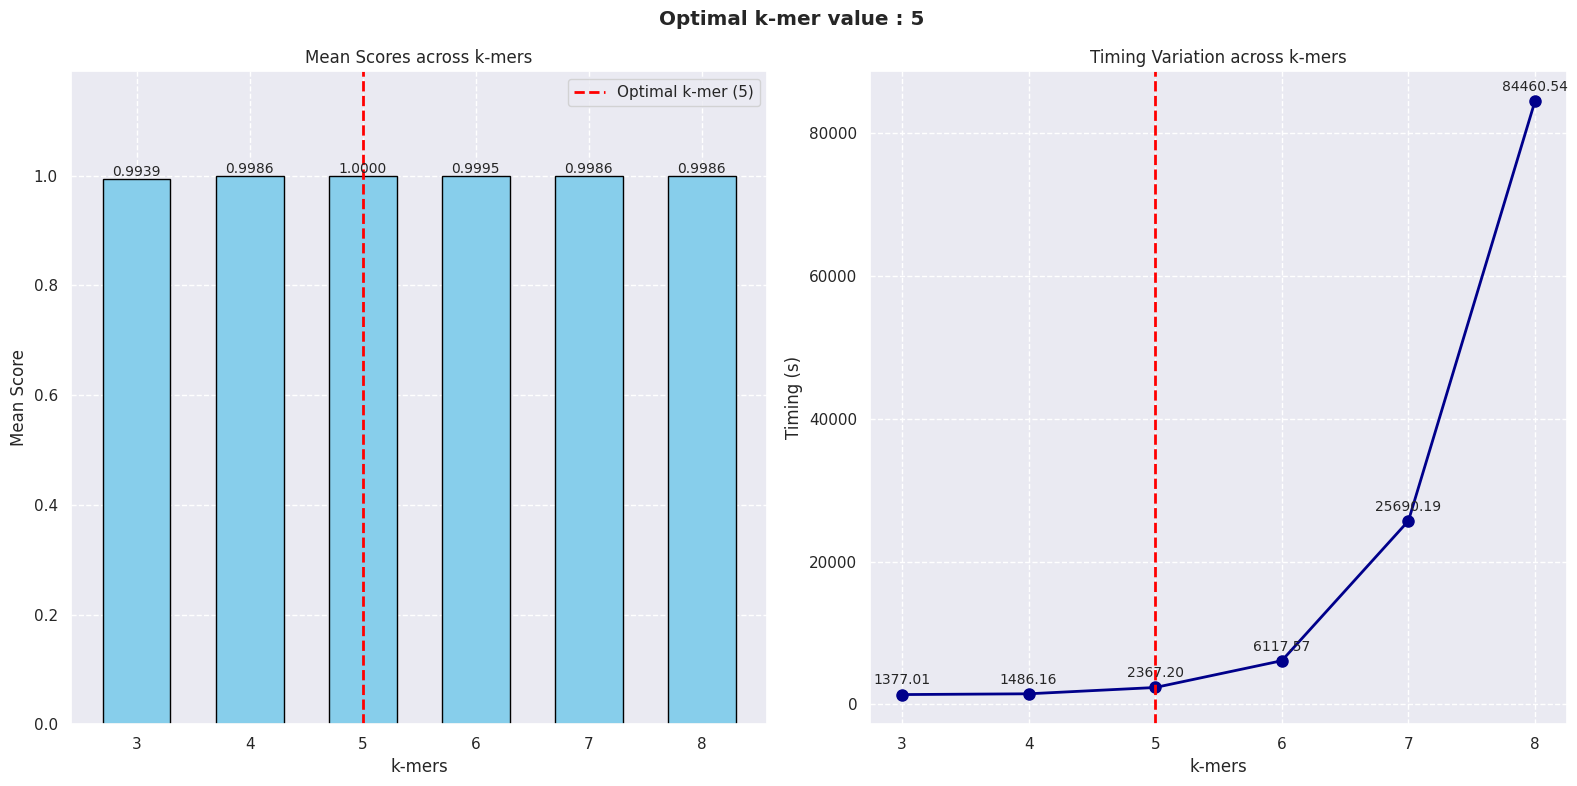

In [ ]:
# @title
# Data k-mers
k_values = [3, 4, 5, 6, 7, 8]
mean_scores = [0.9939, 0.9986, 1.0000, 0.9995, 0.9986, 0.9986]
timings = [1377.01, 1486.16, 2367.20, 6117.57, 25690.19, 84460.54]
best_k = 5

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'Optimal k-mer value : {best_k}',fontweight='bold')

sns.set_theme()

# Subfigure 1: Histogram of mean scores for different k-mers
bars = ax1.bar(k_values, mean_scores, color='skyblue', edgecolor='black', width=0.6)
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

ax1.axvline(best_k, color='red', linestyle='--', linewidth=2, label=f'Optimal k-mer ({best_k})')

# Set labels and title for subfigure 1
ax1.set_xlabel('k-mers', fontsize=12)
ax1.set_ylabel('Mean Score', fontsize=12)
ax1.set_title('Mean Scores across k-mers', fontsize=12)
ax1.grid(linestyle='--')
ax1.set_ylim(0.0, 1.19)
ax1.legend()

# Subfigure 2: Line plot of timing variation over k-mers
lines = ax2.plot(k_values, timings, marker='o', color='darkblue', linestyle='-', linewidth=2, markersize=8)
for i, time in enumerate(timings):
    ax2.text(k_values[i], time + 1000, f'{time:.2f}', ha='center', va='bottom', fontsize=10)  # Adjusted offset here

ax2.axvline(best_k, color='red', linestyle='--', linewidth=2)

# Set labels and title for subfigure 2
ax2.set_xlabel('k-mers', fontsize=12)
ax2.set_ylabel('Timing (s)', fontsize=12)
ax2.set_title('Timing Variation across k-mers', fontsize=12)
ax2.grid(linestyle='--')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/content/optimal_k_mer.pdf', format='pdf')
plt.show()

# **II. FCGR**

In [ ]:
# @title
def optimize_classifier(trial, X_train, y_train,X_test, y_test, classifier_name):
    if classifier_name == 'Random Forest':
        params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 1500),
            'max_depth': trial.suggest_int('rf_max_depth', 1, 20),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20),
            'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
            'criterion': trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif classifier_name == 'XGBoost':
        params = {
            'max_depth': trial.suggest_int('xgb_max_depth', 1, 20),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 1e-3, 1.0, log=True),
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 1500),
            'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
            'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('xgb_gamma', 1e-8, 1.0, log=True)
        }
        model = XGBClassifier(**params, random_state=42, eval_metric='mlogloss')

    else:  # LightGBM
        params = {
            'learning_rate': trial.suggest_float('lgb_learning_rate', 1e-3, 1.0, log=True),
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 1500),
            'max_depth': trial.suggest_int('lgb_max_depth', -1, 20),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 2, 256),
            'feature_fraction': trial.suggest_float('lgb_feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('lgb_bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('lgb_bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('lgb_min_child_samples', 1, 100),
            'lambda_l1': trial.suggest_float('lgb_lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lgb_lambda_l2', 1e-8, 10.0, log=True)
        }
        model = lgb.LGBMClassifier(**params, random_state=42, objective='multiclass', verbose=-1)

    # Fit the model once (without cross-validation) and return accuracy score
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  # Predict on test set
    score = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    return score

In [ ]:
def train_evaluate_models(df, fcgr_values, n_trials=100):
    label_encoder = LabelEncoder()
    df['Lineage_Label'] = label_encoder.fit_transform(df['Lineage'])
    y = df['Lineage_Label']

    best_overall = {'score': 0, 'k': None, 'classifier': None, 'params': None}
    results = {}

    for k in fcgr_values:
        print(f"\nResolution = {k}")
        print("=" * 50)

        start_time = time.time()  # Record the start time
        start_t = datetime.now()
        x = start_t.strftime("%H:%M:%S")
        print(f"Start time : {x}")

        # Convert sequences to a 2D CGR-based feature extraction
        X_fcgr = np.array(df['Sequence'].apply(lambda x: fcgr(x, resolution=k)).tolist())
        X_fcgr = X_fcgr.astype(np.float32)
        X = X_fcgr

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        print(f"Original class distribution: {Counter(y)}")
        print(f"Resampled class distribution: {Counter(y_train_resampled)}")

        results[k] = {}
        best_classifier = {'score': 0, 'name': None, 'params': None}

        for classifier_name in ['Random Forest', 'XGBoost', 'LightGBM']:
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: optimize_classifier(trial, X_train_resampled, y_train_resampled,X_test, y_test, classifier_name), n_trials=n_trials, n_jobs=-1)
            results[k][classifier_name] = {
                'params': study.best_params,
                'score': study.best_value
            }

            print(f"\n{classifier_name}:")
            print(f"Best parameters: {study.best_params}")
            print(f"Best score: {study.best_value:.4f}")

            if study.best_value > best_classifier['score']:
                best_classifier = {'score': study.best_value, 'name': classifier_name, 'params': study.best_params}

        print(f"\nBest classifier for Resolution ={k}: {best_classifier['name']} (Score: {best_classifier['score']:.4f})")

        if best_classifier['score'] > best_overall['score']:
            best_overall = {
                'score': best_classifier['score'],
                'k': k,
                'classifier': best_classifier['name'],
                'params': best_classifier['params']
            }

    print("\n" + "="*50)
    print("Overall Best Combination:")
    print(f"Resolution: {best_overall['k']}")
    print(f"Classifier: {best_overall['classifier']}")
    print(f"Parameters: {best_overall['params']}")
    print(f"Score: {best_overall['score']:.4f}")

    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration
    end_t = datetime.now()
    y = end_t.strftime("%H:%M:%S")
    print(f"Final time: {y}")
    print(f'Total duration  = {duration:.2f} seconds.')

    return results, best_overall

`II.1. Resolution = 16`

In [ ]:
fcgr_values = [16]
results, best_overall = train_evaluate_models(df, fcgr_values, n_trials=10)


Resolution = 16
Start time : 06:17:03


[I 2024-10-22 06:17:34,421] A new study created in memory with name: no-name-cb42e7d8-4536-4576-b2d7-ae0894bada09


Original class distribution: Counter({7: 678, 24: 520, 1: 420, 19: 314, 20: 291, 4: 202, 9: 92, 33: 89, 17: 80, 21: 72, 3: 59, 25: 51, 18: 47, 6: 45, 11: 43, 28: 38, 14: 36, 8: 36, 10: 32, 15: 32, 5: 27, 22: 27, 2: 27, 36: 26, 30: 26, 32: 25, 29: 23, 27: 19, 23: 18, 34: 18, 13: 17, 37: 16, 26: 14, 12: 14, 0: 14, 35: 14, 16: 14, 31: 11})
Resampled class distribution: Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-22 06:18:50,314] Trial 8 finished with value: 0.9971671388101983 and parameters: {'rf_n_estimators': 250, 'rf_max_depth': 9, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 4, 'rf_bootstrap': False, 'rf_criterion': 'gini'}. Best is trial 8 with value: 0.9971671388101983.
[I 2024-10-22 06:19:12,705] Trial 1 finished with value: 0.9971671388101983 and parameters: {'rf_n_estimators': 304, 'rf_max_depth': 12, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 8 with value: 0.9971671388101983.
[I 2024-10-22 06:20:04,213] Trial 7 finished with value: 0.9971671388101983 and parameters: {'rf_n_estimators': 308, 'rf_max_depth': 20, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 13, 'rf_bootstrap': False, 'rf_criterion': 'entropy'}. Best is trial 8 with value: 0.9971671388101983.
[I 2024-10-22 06:20:15,660] Trial 4 finished with value: 0.9957507082152974 and parameters: {'rf_n_estimators': 731, 'rf_max_depth': 11


Random Forest:
Best parameters: {'rf_n_estimators': 250, 'rf_max_depth': 9, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 4, 'rf_bootstrap': False, 'rf_criterion': 'gini'}
Best score: 0.9972


[I 2024-10-22 06:26:00,074] Trial 6 finished with value: 0.9886685552407932 and parameters: {'xgb_max_depth': 2, 'xgb_learning_rate': 0.005161806988005336, 'xgb_n_estimators': 89, 'xgb_min_child_weight': 10, 'xgb_subsample': 0.7981391914299838, 'xgb_colsample_bytree': 0.5602467980377287, 'xgb_gamma': 0.0005842477180869208}. Best is trial 6 with value: 0.9886685552407932.
[I 2024-10-22 06:26:29,959] Trial 8 finished with value: 0.9929178470254958 and parameters: {'xgb_max_depth': 8, 'xgb_learning_rate': 0.016261004310139927, 'xgb_n_estimators': 95, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.5149342403639069, 'xgb_colsample_bytree': 0.802286825905623, 'xgb_gamma': 4.1227178691041466e-05}. Best is trial 8 with value: 0.9929178470254958.
[I 2024-10-22 06:26:59,646] Trial 1 finished with value: 0.9971671388101983 and parameters: {'xgb_max_depth': 4, 'xgb_learning_rate': 0.00517720527594751, 'xgb_n_estimators': 116, 'xgb_min_child_weight': 2, 'xgb_subsample': 0.8708420456326984, 'xgb_cols


XGBoost:
Best parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.057499054419536094, 'xgb_n_estimators': 234, 'xgb_min_child_weight': 9, 'xgb_subsample': 0.71840582055968, 'xgb_colsample_bytree': 0.6845694524321432, 'xgb_gamma': 8.24513656505608e-08}
Best score: 0.9986


[I 2024-10-22 06:35:04,801] Trial 6 finished with value: 0.37960339943342775 and parameters: {'lgb_learning_rate': 0.9324503736453609, 'lgb_n_estimators': 827, 'lgb_max_depth': 6, 'lgb_num_leaves': 125, 'lgb_feature_fraction': 0.9543954145004634, 'lgb_bagging_fraction': 0.5364919838239897, 'lgb_bagging_freq': 5, 'lgb_min_child_samples': 82, 'lgb_lambda_l1': 0.003824184991575381, 'lgb_lambda_l2': 5.151396236788479e-07}. Best is trial 6 with value: 0.37960339943342775.
[I 2024-10-22 06:35:15,599] Trial 2 finished with value: 0.9929178470254958 and parameters: {'lgb_learning_rate': 0.02005540238675882, 'lgb_n_estimators': 429, 'lgb_max_depth': 12, 'lgb_num_leaves': 143, 'lgb_feature_fraction': 0.9629105663767956, 'lgb_bagging_fraction': 0.6676491548975585, 'lgb_bagging_freq': 1, 'lgb_min_child_samples': 62, 'lgb_lambda_l1': 7.437618219844153, 'lgb_lambda_l2': 3.089240076222703e-08}. Best is trial 2 with value: 0.9929178470254958.
[I 2024-10-22 06:35:35,718] Trial 1 finished with value: 0.


LightGBM:
Best parameters: {'lgb_learning_rate': 0.007242972984446977, 'lgb_n_estimators': 1050, 'lgb_max_depth': 3, 'lgb_num_leaves': 250, 'lgb_feature_fraction': 0.7222404724251701, 'lgb_bagging_fraction': 0.7113873407070904, 'lgb_bagging_freq': 4, 'lgb_min_child_samples': 81, 'lgb_lambda_l1': 3.4995468095052158e-06, 'lgb_lambda_l2': 1.398464428959799}
Best score: 0.9986

Best classifier for Resolution =16: XGBoost (Score: 0.9986)

Overall Best Combination:
Resolution: 16
Classifier: XGBoost
Parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.057499054419536094, 'xgb_n_estimators': 234, 'xgb_min_child_weight': 9, 'xgb_subsample': 0.71840582055968, 'xgb_colsample_bytree': 0.6845694524321432, 'xgb_gamma': 8.24513656505608e-08}
Score: 0.9986
Final time: 06:38:24
Total duration  = 1280.82 seconds.


`II.2. Resolution = 32`

In [ ]:
fcgr_values = [32]
results, best_overall = train_evaluate_models(df, fcgr_values, n_trials=10)


Resolution = 32
Start time : 06:38:50


[I 2024-10-22 06:39:24,768] A new study created in memory with name: no-name-7d4e6532-6249-4545-84fd-f8d43d85d79c


Original class distribution: Counter({7: 678, 24: 520, 1: 420, 19: 314, 20: 291, 4: 202, 9: 92, 33: 89, 17: 80, 21: 72, 3: 59, 25: 51, 18: 47, 6: 45, 11: 43, 28: 38, 14: 36, 8: 36, 10: 32, 15: 32, 5: 27, 22: 27, 2: 27, 36: 26, 30: 26, 32: 25, 29: 23, 27: 19, 23: 18, 34: 18, 13: 17, 37: 16, 26: 14, 12: 14, 0: 14, 35: 14, 16: 14, 31: 11})
Resampled class distribution: Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-22 06:39:55,718] Trial 6 finished with value: 1.0 and parameters: {'rf_n_estimators': 77, 'rf_max_depth': 12, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 5, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 6 with value: 1.0.
[I 2024-10-22 06:41:35,618] Trial 0 finished with value: 0.9943342776203966 and parameters: {'rf_n_estimators': 1171, 'rf_max_depth': 3, 'rf_min_samples_split': 16, 'rf_min_samples_leaf': 9, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 6 with value: 1.0.
[I 2024-10-22 06:43:02,614] Trial 4 finished with value: 1.0 and parameters: {'rf_n_estimators': 602, 'rf_max_depth': 8, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 17, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 6 with value: 1.0.
[I 2024-10-22 06:44:50,940] Trial 8 finished with value: 1.0 and parameters: {'rf_n_estimators': 656, 'rf_max_depth': 18, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 12, 'rf_bootstrap': False, 'rf_criterion'


Random Forest:
Best parameters: {'rf_n_estimators': 77, 'rf_max_depth': 12, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 5, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}
Best score: 1.0000


[I 2024-10-22 06:59:14,585] Trial 7 finished with value: 1.0 and parameters: {'xgb_max_depth': 15, 'xgb_learning_rate': 0.027102107707753603, 'xgb_n_estimators': 253, 'xgb_min_child_weight': 9, 'xgb_subsample': 0.6411199183307126, 'xgb_colsample_bytree': 0.5212658551242859, 'xgb_gamma': 6.426405949392993e-06}. Best is trial 7 with value: 1.0.
[I 2024-10-22 07:01:32,996] Trial 9 finished with value: 1.0 and parameters: {'xgb_max_depth': 9, 'xgb_learning_rate': 0.012599116032468263, 'xgb_n_estimators': 289, 'xgb_min_child_weight': 4, 'xgb_subsample': 0.50794480884085, 'xgb_colsample_bytree': 0.6471965914995204, 'xgb_gamma': 6.999458307660761e-07}. Best is trial 7 with value: 1.0.
[I 2024-10-22 07:02:11,035] Trial 6 finished with value: 0.9773371104815864 and parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.7349077998054938, 'xgb_n_estimators': 548, 'xgb_min_child_weight': 10, 'xgb_subsample': 0.8491365252460932, 'xgb_colsample_bytree': 0.7093816059381002, 'xgb_gamma': 0.0001041431


XGBoost:
Best parameters: {'xgb_max_depth': 15, 'xgb_learning_rate': 0.027102107707753603, 'xgb_n_estimators': 253, 'xgb_min_child_weight': 9, 'xgb_subsample': 0.6411199183307126, 'xgb_colsample_bytree': 0.5212658551242859, 'xgb_gamma': 6.426405949392993e-06}
Best score: 1.0000


[I 2024-10-22 07:12:01,276] Trial 3 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.03736971096800073, 'lgb_n_estimators': 228, 'lgb_max_depth': 15, 'lgb_num_leaves': 55, 'lgb_feature_fraction': 0.9760627324289601, 'lgb_bagging_fraction': 0.8882937697233584, 'lgb_bagging_freq': 6, 'lgb_min_child_samples': 26, 'lgb_lambda_l1': 4.700131157518051, 'lgb_lambda_l2': 3.264265301341891e-05}. Best is trial 3 with value: 0.9985835694050992.
[I 2024-10-22 07:12:23,568] Trial 7 finished with value: 0.9943342776203966 and parameters: {'lgb_learning_rate': 0.8603891117199567, 'lgb_n_estimators': 372, 'lgb_max_depth': 11, 'lgb_num_leaves': 140, 'lgb_feature_fraction': 0.7361806194820704, 'lgb_bagging_fraction': 0.6889651479576138, 'lgb_bagging_freq': 7, 'lgb_min_child_samples': 50, 'lgb_lambda_l1': 0.0004023854653473325, 'lgb_lambda_l2': 1.4386241911046977}. Best is trial 3 with value: 0.9985835694050992.
[I 2024-10-22 07:13:18,546] Trial 4 finished with value: 1.0 an


LightGBM:
Best parameters: {'lgb_learning_rate': 0.08704476074172247, 'lgb_n_estimators': 836, 'lgb_max_depth': 1, 'lgb_num_leaves': 26, 'lgb_feature_fraction': 0.8267471127690582, 'lgb_bagging_fraction': 0.5360632117552195, 'lgb_bagging_freq': 1, 'lgb_min_child_samples': 25, 'lgb_lambda_l1': 0.0007832835585323356, 'lgb_lambda_l2': 1.035613368080664e-06}
Best score: 1.0000

Best classifier for Resolution =32: Random Forest (Score: 1.0000)

Overall Best Combination:
Resolution: 32
Classifier: Random Forest
Parameters: {'rf_n_estimators': 77, 'rf_max_depth': 12, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 5, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}
Score: 1.0000
Final time: 07:16:33
Total duration  = 2263.35 seconds.


`II.3. Resolution = 64`

In [ ]:
fcgr_values = [64]
results, best_overall = train_evaluate_models(df, fcgr_values, n_trials=10)


Resolution = 64
Start time : 07:19:56


[I 2024-10-22 07:20:49,870] A new study created in memory with name: no-name-27f323c7-c688-4a66-9d7c-804fe47ff8fa


Original class distribution: Counter({7: 678, 24: 520, 1: 420, 19: 314, 20: 291, 4: 202, 9: 92, 33: 89, 17: 80, 21: 72, 3: 59, 25: 51, 18: 47, 6: 45, 11: 43, 28: 38, 14: 36, 8: 36, 10: 32, 15: 32, 5: 27, 22: 27, 2: 27, 36: 26, 30: 26, 32: 25, 29: 23, 27: 19, 23: 18, 34: 18, 13: 17, 37: 16, 26: 14, 12: 14, 0: 14, 35: 14, 16: 14, 31: 11})
Resampled class distribution: Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-22 07:22:14,523] Trial 6 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 230, 'rf_max_depth': 12, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 6, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 6 with value: 0.9985835694050992.
[I 2024-10-22 07:23:05,974] Trial 8 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 595, 'rf_max_depth': 6, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 19, 'rf_bootstrap': True, 'rf_criterion': 'gini'}. Best is trial 6 with value: 0.9985835694050992.
[I 2024-10-22 07:25:06,906] Trial 5 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 427, 'rf_max_depth': 18, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 12, 'rf_bootstrap': False, 'rf_criterion': 'gini'}. Best is trial 6 with value: 0.9985835694050992.
[I 2024-10-22 07:25:49,835] Trial 1 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 559, 'rf_max_depth': 12, 'r


Random Forest:
Best parameters: {'rf_n_estimators': 230, 'rf_max_depth': 12, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 6, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}
Best score: 0.9986


[I 2024-10-22 08:13:20,251] Trial 8 finished with value: 1.0 and parameters: {'xgb_max_depth': 11, 'xgb_learning_rate': 0.0018669875922640957, 'xgb_n_estimators': 384, 'xgb_min_child_weight': 8, 'xgb_subsample': 0.9125198549952334, 'xgb_colsample_bytree': 0.5414406601723618, 'xgb_gamma': 0.0003094817799729034}. Best is trial 8 with value: 1.0.
[I 2024-10-22 08:29:24,530] Trial 5 finished with value: 1.0 and parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.023048339657575224, 'xgb_n_estimators': 758, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.616776379133003, 'xgb_colsample_bytree': 0.8898548775304977, 'xgb_gamma': 0.016900607304917575}. Best is trial 8 with value: 1.0.
[I 2024-10-22 08:30:56,713] Trial 6 finished with value: 1.0 and parameters: {'xgb_max_depth': 2, 'xgb_learning_rate': 0.002464629131711886, 'xgb_n_estimators': 609, 'xgb_min_child_weight': 6, 'xgb_subsample': 0.7629029841214288, 'xgb_colsample_bytree': 0.5955467889550978, 'xgb_gamma': 1.8360776563892534e-08}.


XGBoost:
Best parameters: {'xgb_max_depth': 11, 'xgb_learning_rate': 0.0018669875922640957, 'xgb_n_estimators': 384, 'xgb_min_child_weight': 8, 'xgb_subsample': 0.9125198549952334, 'xgb_colsample_bytree': 0.5414406601723618, 'xgb_gamma': 0.0003094817799729034}
Best score: 1.0000


[I 2024-10-22 09:03:04,468] Trial 5 finished with value: 1.0 and parameters: {'lgb_learning_rate': 0.0679753071659715, 'lgb_n_estimators': 83, 'lgb_max_depth': 3, 'lgb_num_leaves': 3, 'lgb_feature_fraction': 0.7840254189776428, 'lgb_bagging_fraction': 0.9634375426004778, 'lgb_bagging_freq': 2, 'lgb_min_child_samples': 64, 'lgb_lambda_l1': 1.1450310481896837e-07, 'lgb_lambda_l2': 0.0003578666671498155}. Best is trial 5 with value: 1.0.
[I 2024-10-22 09:04:35,128] Trial 7 finished with value: 1.0 and parameters: {'lgb_learning_rate': 0.19089921430725304, 'lgb_n_estimators': 150, 'lgb_max_depth': 10, 'lgb_num_leaves': 25, 'lgb_feature_fraction': 0.693711859176736, 'lgb_bagging_fraction': 0.7630279348429531, 'lgb_bagging_freq': 3, 'lgb_min_child_samples': 38, 'lgb_lambda_l1': 3.869947839573892e-07, 'lgb_lambda_l2': 0.043385295926112455}. Best is trial 5 with value: 1.0.
[I 2024-10-22 09:06:52,772] Trial 1 finished with value: 0.9985835694050992 and parameters: {'lgb_learning_rate': 0.12221


LightGBM:
Best parameters: {'lgb_learning_rate': 0.0679753071659715, 'lgb_n_estimators': 83, 'lgb_max_depth': 3, 'lgb_num_leaves': 3, 'lgb_feature_fraction': 0.7840254189776428, 'lgb_bagging_fraction': 0.9634375426004778, 'lgb_bagging_freq': 2, 'lgb_min_child_samples': 64, 'lgb_lambda_l1': 1.1450310481896837e-07, 'lgb_lambda_l2': 0.0003578666671498155}
Best score: 1.0000

Best classifier for Resolution =64: XGBoost (Score: 1.0000)

Overall Best Combination:
Resolution: 64
Classifier: XGBoost
Parameters: {'xgb_max_depth': 11, 'xgb_learning_rate': 0.0018669875922640957, 'xgb_n_estimators': 384, 'xgb_min_child_weight': 8, 'xgb_subsample': 0.9125198549952334, 'xgb_colsample_bytree': 0.5414406601723618, 'xgb_gamma': 0.0003094817799729034}
Score: 1.0000
Final time: 09:23:08
Total duration  = 7391.19 seconds.


`II.4. Resolution = 128`

In [ ]:
fcgr_values = [128]
results, best_overall = train_evaluate_models(df, fcgr_values, n_trials=10)


Resolution = 128
Start time : 09:46:31


[I 2024-10-22 09:48:42,850] A new study created in memory with name: no-name-6521eeaa-06ad-4916-8b6f-a98015278d1a


Original class distribution: Counter({7: 678, 24: 520, 1: 420, 19: 314, 20: 291, 4: 202, 9: 92, 33: 89, 17: 80, 21: 72, 3: 59, 25: 51, 18: 47, 6: 45, 11: 43, 28: 38, 14: 36, 8: 36, 10: 32, 15: 32, 5: 27, 22: 27, 2: 27, 36: 26, 30: 26, 32: 25, 29: 23, 27: 19, 23: 18, 34: 18, 13: 17, 37: 16, 26: 14, 12: 14, 0: 14, 35: 14, 16: 14, 31: 11})
Resampled class distribution: Counter({1: 542, 20: 542, 7: 542, 19: 542, 9: 542, 24: 542, 22: 542, 5: 542, 34: 542, 37: 542, 4: 542, 3: 542, 32: 542, 21: 542, 17: 542, 18: 542, 26: 542, 2: 542, 13: 542, 36: 542, 30: 542, 25: 542, 33: 542, 28: 542, 0: 542, 35: 542, 10: 542, 15: 542, 31: 542, 8: 542, 16: 542, 6: 542, 14: 542, 23: 542, 29: 542, 11: 542, 27: 542, 12: 542})


[I 2024-10-22 09:49:33,576] Trial 2 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 150, 'rf_max_depth': 19, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 2 with value: 0.9985835694050992.
[I 2024-10-22 09:52:26,684] Trial 3 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 718, 'rf_max_depth': 7, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 19, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}. Best is trial 2 with value: 0.9985835694050992.
[I 2024-10-22 09:53:44,522] Trial 1 finished with value: 0.9730878186968839 and parameters: {'rf_n_estimators': 1497, 'rf_max_depth': 3, 'rf_min_samples_split': 16, 'rf_min_samples_leaf': 19, 'rf_bootstrap': False, 'rf_criterion': 'gini'}. Best is trial 2 with value: 0.9985835694050992.
[I 2024-10-22 09:53:54,148] Trial 4 finished with value: 0.9985835694050992 and parameters: {'rf_n_estimators': 871, 'rf_max_depth': 1


Random Forest:
Best parameters: {'rf_n_estimators': 150, 'rf_max_depth': 19, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}
Best score: 0.9986


[I 2024-10-22 11:52:12,723] Trial 8 finished with value: 0.9929178470254958 and parameters: {'xgb_max_depth': 1, 'xgb_learning_rate': 0.07975215666006162, 'xgb_n_estimators': 201, 'xgb_min_child_weight': 6, 'xgb_subsample': 0.5207234275741336, 'xgb_colsample_bytree': 0.9737894443795134, 'xgb_gamma': 3.745986518371002e-07}. Best is trial 8 with value: 0.9929178470254958.
[I 2024-10-22 13:35:31,442] Trial 7 finished with value: 0.9957507082152974 and parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.006819639433320327, 'xgb_n_estimators': 279, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.7302366547504002, 'xgb_colsample_bytree': 0.8980870838636121, 'xgb_gamma': 4.893140375027796e-05}. Best is trial 7 with value: 0.9957507082152974.
[I 2024-10-22 14:07:15,536] Trial 1 finished with value: 0.9943342776203966 and parameters: {'xgb_max_depth': 5, 'xgb_learning_rate': 0.04100445083970709, 'xgb_n_estimators': 583, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.8067920258093326, 'xgb_col


XGBoost:
Best parameters: {'xgb_max_depth': 13, 'xgb_learning_rate': 0.006819639433320327, 'xgb_n_estimators': 279, 'xgb_min_child_weight': 7, 'xgb_subsample': 0.7302366547504002, 'xgb_colsample_bytree': 0.8980870838636121, 'xgb_gamma': 4.893140375027796e-05}
Best score: 0.9958


[I 2024-10-22 16:18:43,239] Trial 5 finished with value: 0.9957507082152974 and parameters: {'lgb_learning_rate': 0.015483847459630513, 'lgb_n_estimators': 124, 'lgb_max_depth': 19, 'lgb_num_leaves': 191, 'lgb_feature_fraction': 0.7466668614927332, 'lgb_bagging_fraction': 0.885548175675006, 'lgb_bagging_freq': 5, 'lgb_min_child_samples': 95, 'lgb_lambda_l1': 1.5426634277459993e-05, 'lgb_lambda_l2': 1.1540386567804275e-08}. Best is trial 5 with value: 0.9957507082152974.
[I 2024-10-22 16:51:00,845] Trial 9 finished with value: 0.9971671388101983 and parameters: {'lgb_learning_rate': 0.0797379431354337, 'lgb_n_estimators': 414, 'lgb_max_depth': 10, 'lgb_num_leaves': 3, 'lgb_feature_fraction': 0.5777347184786181, 'lgb_bagging_fraction': 0.6894344381705675, 'lgb_bagging_freq': 1, 'lgb_min_child_samples': 64, 'lgb_lambda_l1': 6.620737714548394e-06, 'lgb_lambda_l2': 9.77188160239575e-05}. Best is trial 9 with value: 0.9971671388101983.
[I 2024-10-22 17:11:38,376] Trial 6 finished with value:


LightGBM:
Best parameters: {'lgb_learning_rate': 0.0797379431354337, 'lgb_n_estimators': 414, 'lgb_max_depth': 10, 'lgb_num_leaves': 3, 'lgb_feature_fraction': 0.5777347184786181, 'lgb_bagging_fraction': 0.6894344381705675, 'lgb_bagging_freq': 1, 'lgb_min_child_samples': 64, 'lgb_lambda_l1': 6.620737714548394e-06, 'lgb_lambda_l2': 9.77188160239575e-05}
Best score: 0.9972

Best classifier for Resolution =128: Random Forest (Score: 0.9986)

Overall Best Combination:
Resolution: 128
Classifier: Random Forest
Parameters: {'rf_n_estimators': 150, 'rf_max_depth': 19, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True, 'rf_criterion': 'entropy'}
Score: 0.9986
Final time: 18:40:12
Total duration  = 32021.16 seconds.


`II.5. Summary FCGR`

In [ ]:
# @title
# Data : Scores
data = {
    'Model': ['RF', 'XGBoost', 'LightGBM'],
    '16-FCGR': [0.9972, 0.9986, 0.9986],
    '32-FCGR': [1.0000, 1.0000, 1.0000],
    '64-FCGR': [0.9986, 1.0000, 1.0000],
    '128-FCGR': [0.9986, 0.9958, 0.9972]
}


# Create DataFrame
df_fcgr = pd.DataFrame(data)

# Display the DataFrame
df_fcgr.head()

,Model,16-FCGR,32-FCGR,64-FCGR,128-FCGR
0,RF,0.9972,1.0,0.9986,0.9986
1,XGBoost,0.9986,1.0,1.0000,0.9958
2,LightGBM,0.9986,1.0,1.0000,0.9972


In [ ]:
# @title
# Print the mean score for each column:
print(f"Mean score 16-FCGR: {df_fcgr['16-FCGR'].mean():.4f}")
print(f"Mean score 32-FCGR: {df_fcgr['32-FCGR'].mean():.4f}")
print(f"Mean score 64-FCGR: {df_fcgr['64-FCGR'].mean():.4f}")
print(f"Mean score 128-FCGR: {df_fcgr['128-FCGR'].mean():.4f}")

Mean score 16-FCGR: 0.9981
Mean score 32-FCGR: 1.0000
Mean score 64-FCGR: 0.9995
Mean score 128-FCGR: 0.9972


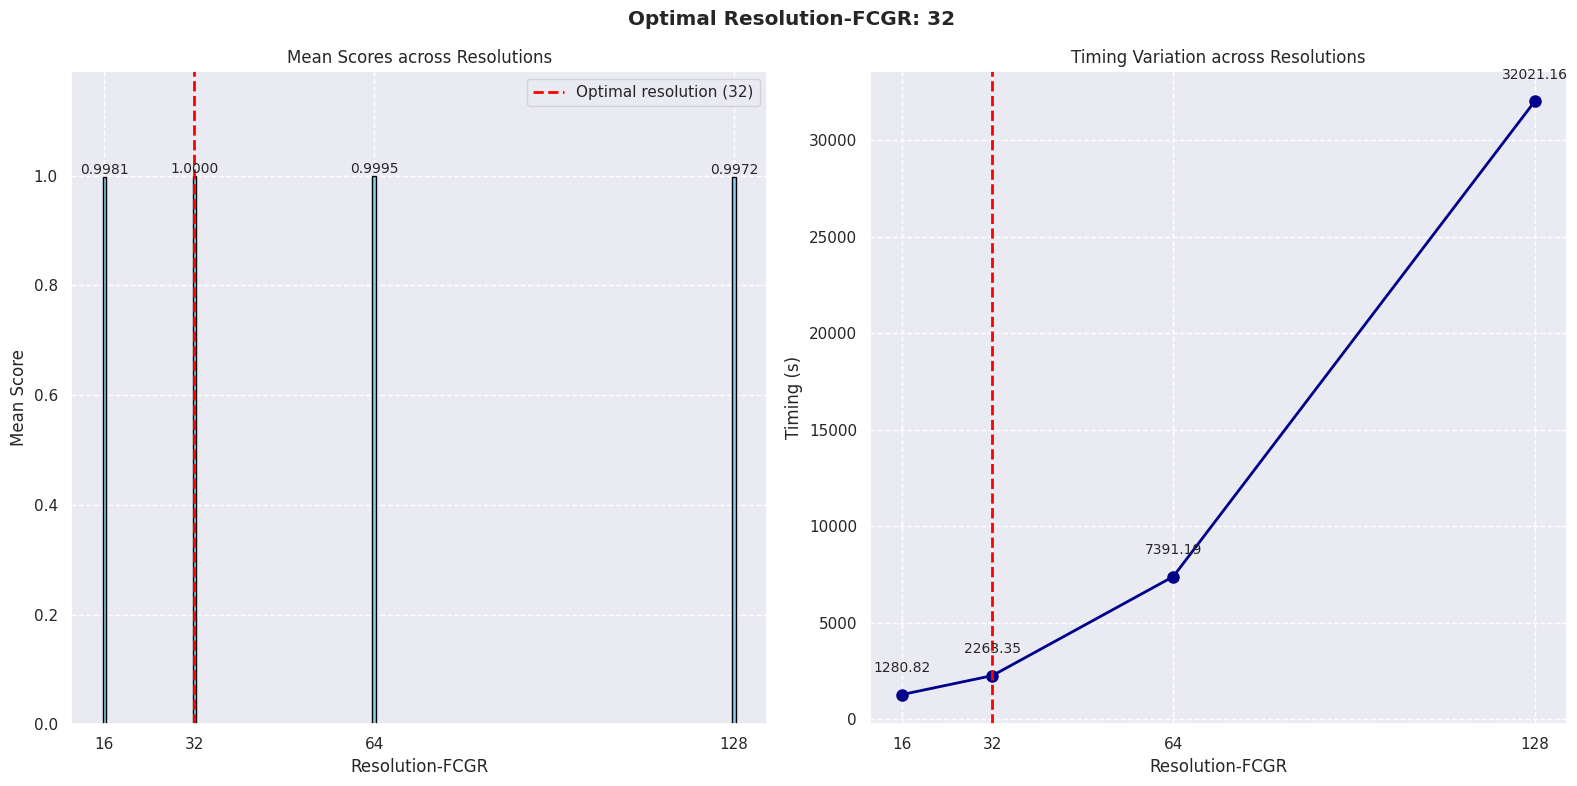

In [ ]:
# @title
# Data fcgr
fcgr_values = [16, 32, 64, 128]
mean_scores = [0.9981, 1.0000, 0.9995, 0.9972]
timings = [1280.82, 2263.35, 7391.19, 32021.16]
best_fcgr = 32

# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'Optimal Resolution-FCGR: {best_fcgr}', fontweight='bold')

sns.set_theme()

# Subfigure 1: Histogram of mean scores for different k-mers
bars = ax1.bar(fcgr_values, mean_scores, color='skyblue', edgecolor='black', width=0.6)
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

ax1.axvline(best_fcgr, color='red', linestyle='--', linewidth=2, label=f'Optimal resolution ({best_fcgr})')

# Set labels and title for subfigure 1
ax1.set_xlabel('Resolution-FCGR', fontsize=12)
ax1.set_ylabel('Mean Score', fontsize=12)
ax1.set_title('Mean Scores across Resolutions', fontsize=12)
ax1.grid(linestyle='--')
ax1.set_ylim(0.0, 1.19)
ax1.set_xticks(fcgr_values)  # Set x-ticks to specific fcgr values
ax1.legend()

# Subfigure 2: Line plot of timing variation over k-mers
ax2.plot(fcgr_values, timings, marker='o', color='darkblue', linestyle='-', linewidth=2, markersize=8)
for i, time in enumerate(timings):
    ax2.text(fcgr_values[i], time + 1000, f'{time:.2f}', ha='center', va='bottom', fontsize=10)

ax2.axvline(best_fcgr, color='red', linestyle='--', linewidth=2, label=f'Optimal resolution: ({best_fcgr})')

# Set labels and title for subfigure 2
ax2.set_xlabel('Resolution-FCGR', fontsize=12)
ax2.set_ylabel('Timing (s)', fontsize=12)
ax2.set_title('Timing Variation across Resolutions', fontsize=12)
ax2.grid(linestyle='--')
ax2.set_xticks(fcgr_values)  # Set x-ticks to specific fcgr values

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/content/optimal_fcgr.pdf', format='pdf')
plt.show()